Imports and load charged hadrons from file:

In [124]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics
from particle import literals as lp
from fcc_python_tools import plotting
import tensorflow as tf
import zfit
import random

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

file_type = "p8_ee_Zbb_ecm91_EvtGen_Bu2D0Pi"

#Load 1 sub-file of 100k events
file = uproot.open(f"/eos/experiment/fcc/ee/generation/DelphesEvents/fcc_tmp/{file_type}/events_001133159.root")
tree = file['events']

#Get all the variables in the tree
vars = tree.keys()

#Loacation of the reco particles
h_container = "ReconstructedParticles"
h_c = f'{h_container}/{h_container}'

#Keep the variables that aren't covMatrix
keep_vars = []
for v in vars:
    if("covMatrix" not in v and h_c in v):
        keep_vars.append(v)

n_keep = 10000
h = tree.arrays(keep_vars,how="zip")[:n_keep]

Build $D^0$ candidates:

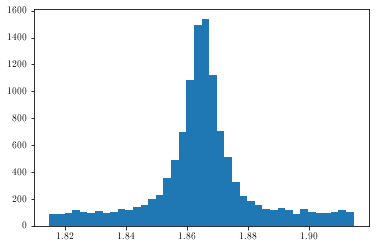

In [125]:
h[h_c,'p'] = kinematics.calc_p(h,h_c)
p_cut = h[h_c,"p"] > 0.
h = h[p_cut]

pi_cut = abs(h[h_c,"mass"] - lp.pi_plus.mass/1000.) < 1e-4
h["pi"] = h[h_c][pi_cut]

k_cut = abs(h[h_c,"mass"] - lp.K_plus.mass/1000.) < 1e-4
h["k"] = h[h_c][k_cut]

D = ak.cartesian({"k": h["k"], "pi": h["pi"]})
D_cut = np.sign(D["k","charge"]) != np.sign(D["pi","charge"])
D = D[D_cut]

PDG_K_m = lp.K_plus.mass/1000.
PDG_pi_m = lp.pi_plus.mass/1000.
D["mass"] = kinematics.mass([D["k"], D["pi"]], [PDG_K_m, PDG_pi_m])

PDG_D_m = lp.D_0.mass/1000.
D_window = 0.05
D_cut = abs(D["mass"] - PDG_D_m) < D_window
D = D[D_cut]

plt.hist(ak.flatten(D["mass"]),bins=40)
plt.show()

Build $B^\pm \to D^0 \pi^\pm$ candidates, keeping only those where the $K$ from the $D^0$ has the same charge as the $\pi$ produced in the $B^\pm$ decay:

In [126]:
B = ak.cartesian({"D_k": D["k"], "D_pi": D["pi"], "pi": h["pi"]})
B_cut = np.sign(B["D_k","charge"]) == np.sign(B["pi","charge"])
B = B[B_cut]
B["mass"] = kinematics.mass([B["D_k"], B["D_pi"], B["pi"]], [PDG_K_m, PDG_pi_m, PDG_pi_m])

Keep $B^\pm$ candidates within a certain mass range and plot:

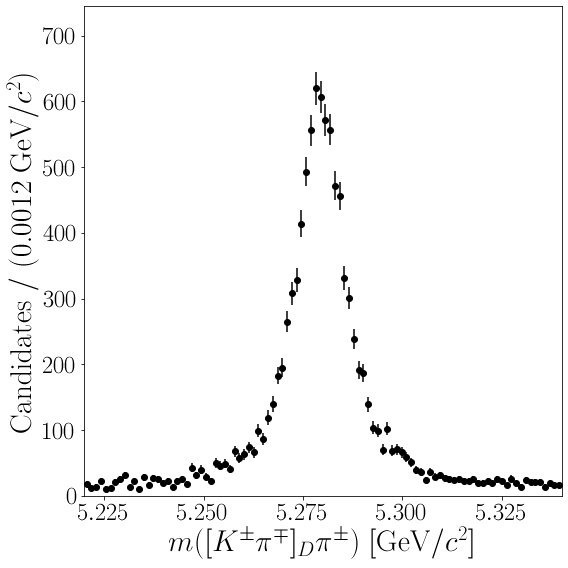

In [127]:
low = 5.22
high = 5.34
B_cut = np.logical_and(B["mass"] > low, B["mass"] < high)
B = B[B_cut]

plotting.errorbar_hist(B,"mass","B","$m([K^\pm \pi^\mp]_D \pi^\pm)$","GeV/$c^2$",low,high,100)

Fit the distribution with zfit, including a signal peak component and an exponential component for random combinations:

In [134]:
obs = zfit.Space('mB', limits=(low, high))

rand = random.randint(0,999)
#Signal PDF
B_mu = zfit.Parameter(f"B_mu_{rand}", 5.279, low, high)
B_sigma = zfit.Parameter(f"B_sigma_{rand}", 0.005, 0., 0.1)
B_alphaL = zfit.Parameter(f"B_alphaL_{rand}", 0.5, 0., 5.)
B_nL = zfit.Parameter(f"B_nL_{rand}", 100., 0., 200.)
B_alphaR = zfit.Parameter(f"B_alphaR_{rand}", -0.5, -5., 0.)
B_nR = zfit.Parameter(f"B_nR_{rand}", 100., 0., 200.)
frac = zfit.Parameter(f"frac_{rand}", 0.5, 0., 1.)

n_sig = zfit.Parameter(f"n_sig_{rand}", 8000., 0., 20000.)

pdf_sigL = zfit.pdf.CrystalBall(obs=obs, mu=B_mu, sigma=B_sigma, alpha=B_alphaL, n=B_nL)
pdf_sigR = zfit.pdf.CrystalBall(obs=obs, mu=B_mu, sigma=B_sigma, alpha=B_alphaR, n=B_nR)
pdf_sig = zfit.pdf.SumPDF([pdf_sigL, pdf_sigR], frac).create_extended(n_sig)

#Background PDF
comb = zfit.Parameter(f"comb_{rand}", -0.1, -1, 1.)

n_bkg = zfit.Parameter(f"n_bkg_{rand}", 500., 0., 10000.)

pdf_bkg = zfit.pdf.Chebyshev(obs=obs, coeffs=[comb]).create_extended(n_bkg)

#Total PDF
pdf = zfit.pdf.SumPDF([pdf_sig, pdf_bkg])

In [129]:
data_np = ak.to_numpy(ak.flatten(B["mass"]))
data = zfit.Data.from_numpy(obs=obs, array=data_np)

In [135]:
nll = zfit.loss.ExtendedUnbinnedNLL(model=pdf, data=data)
minimizer = zfit.minimize.Minuit(tolerance=1e-5)
result = minimizer.minimize(nll)
param_errors, _ = result.errors(method="minuit_minos")

print("m(B) fit function minimum:", result.fmin)
print("m(B) fit converged:", result.converged)
print("m(B) fit full minimizer information:", result.info)

params = result.params
print(params)

n_sig_val = params[n_sig]['value']

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -1.153e+05                 │      Ncalls = 1246 (1246 total)      │
│ EDM = 2.29e-06 (Goal: 1e-05)     │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
m(B) fit function minimum: -115331.29322846365
m(B) fit converged: True
m(B) fit full minimizer information: {'n_eval': 1246, 'n_iter': 1246, 'original': FMin(fval=-115331.29322846365, edm=2.291574336492642e-06, tolerance=0.01, nfcn=1246, n

Plot the fit result:

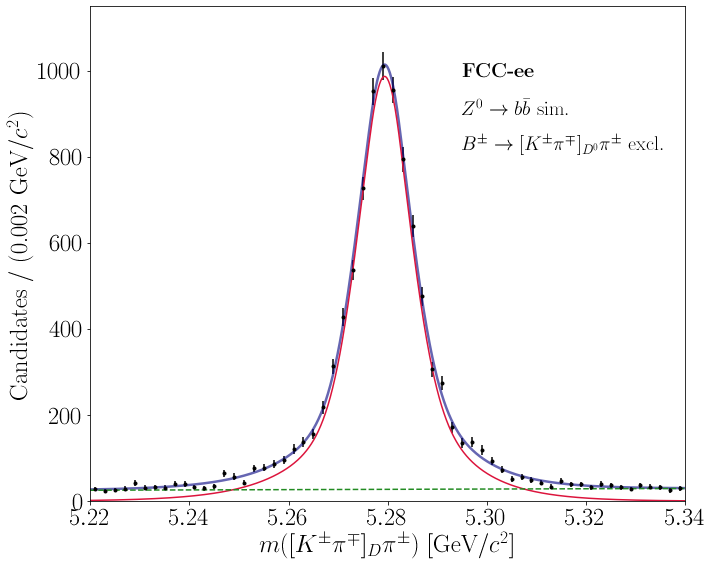

In [136]:
fig,ax = plt.subplots(figsize=(10,8))
lower, upper = obs.limits
low = lower[-1][0]
high = upper[0][0]
bin_width = 0.002
bins = int(float(high - low)/bin_width)
counts, bin_edges = np.histogram(data_np, bins, range=(low,high))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
err = np.sqrt(counts)
plt.errorbar(bin_centres, counts, yerr=err, fmt='o', markersize=3, color='black')
x_plot = np.linspace(low, high, num=1000)
y_plot_tot = zfit.run(pdf.pdf(x_plot, norm_range=obs))
plt.plot(x_plot, y_plot_tot*len(data_np)/bins*obs.area(), color='navy', linewidth=2.5, alpha=0.6)
y_plot_sig = zfit.run(pdf_sig.pdf(x_plot, norm_range=obs))
plt.plot(x_plot,y_plot_sig*params[n_sig]['value']/bins*obs.area(), color='crimson')
y_plot_bkg = zfit.run(pdf_bkg.pdf(x_plot, norm_range=obs))
plt.plot(x_plot,y_plot_bkg*params[n_bkg]['value']/bins*obs.area(), color='forestgreen', linestyle='dashed')
ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylabel("Candidates / (%.3f GeV/$c^2$)" % bin_width,fontsize=25)
plt.xlabel("$m([K^\pm \pi^\mp]_D \pi^\pm)$ [GeV/$c^2$]",fontsize=25)
plt.xlim(low,high)
ymin, ymax = plt.ylim()
plt.ylim(0,1.05*ymax)
plt.text(5.295,0.9*ymax,"\\textbf{FCC-ee}",fontsize=20)
plt.text(5.295,0.82*ymax,"$Z^0 \\to b\\bar{b}$ sim.",fontsize=20)
plt.text(5.295,0.74*ymax,"$B^\\pm \\to [K^\pm \pi^\mp]_{D^0} \\pi^\\pm$ excl.",fontsize=20)
plt.tight_layout()
fig.savefig(loc.PLOTS+f"/{file_type}_Bu_M_fit.pdf")

Estimate the expected yield of this mode per year and per experiment:

In [138]:
#Number of Z's produced per year (4) per experiment (2)
N_Z = 3e12 * 0.25 * 0.5
#Number of b quarks produced
N_b = 2 * 0.1512 * N_Z
#Number of B -> D0 pi produced
N_Bu2D0Pi = N_b * 4.68e-3 * 0.0395

print("N expected per year per exp = %.3e" % N_Bu2D0Pi)

N expected per year per exp = 2.096e+07


Fit the D0 peak to measure resolution:

In [139]:
low = PDG_D_m - D_window
high = PDG_D_m + D_window
obs_D = zfit.Space('mD', limits=(low, high))

rand = random.randint(0,999)
#Signal PDF
D_mu = zfit.Parameter(f"D_mu_{rand}", 1.864, low, high)
D_sigma = zfit.Parameter(f"D_sigma_{rand}", 0.004, 0., 0.02)
D_alphaL = zfit.Parameter(f"D_alphaL_{rand}", 0.5, 0., 5.)
D_nL = zfit.Parameter(f"D_nL_{rand}", 10., 0., 200.)
D_alphaR = zfit.Parameter(f"D_alphaR_{rand}", -0.5, -5., 0.)
D_nR = zfit.Parameter(f"D_nR_{rand}", 10., 0., 200.)
D_frac = zfit.Parameter(f"D_frac_{rand}", 0.4, 0., 1.)

n_sig_D = zfit.Parameter(f"n_sig_D_{rand}", 7000, 0., 20000.)

pdf_sigL_D = zfit.pdf.CrystalBall(obs=obs_D, mu=D_mu, sigma=D_sigma, alpha=D_alphaL, n=D_nL)
pdf_sigR_D = zfit.pdf.CrystalBall(obs=obs_D, mu=D_mu, sigma=D_sigma, alpha=D_alphaR, n=D_nR)
pdf_sig_D = zfit.pdf.SumPDF([pdf_sigL_D, pdf_sigR_D], D_frac).create_extended(n_sig_D)

#Background PDF
comb_D = zfit.Parameter(f"comb_D_{rand}", 0., -0.5, 0.5)

n_bkg_D = zfit.Parameter(f"n_bkg_D_{rand}", 500., 0., 10000.)

pdf_bkg_D = zfit.pdf.Chebyshev(obs=obs_D, coeffs=[comb_D]).create_extended(n_bkg_D)

#Total PDF
pdf_D = zfit.pdf.SumPDF([pdf_sig_D, pdf_bkg_D])

In [140]:
D_data_np = ak.to_numpy(ak.flatten(D["mass"]))
D_data = zfit.Data.from_numpy(obs=obs_D, array=D_data_np)

In [141]:
nll = zfit.loss.ExtendedUnbinnedNLL(model=pdf_D, data=D_data)
minimizer = zfit.minimize.Minuit(tolerance=1e-5)
result = minimizer.minimize(nll)
param_errors, _ = result.errors(method="minuit_minos")

print("m(D) fit function minimum:", result.fmin)
print("m(D) fit converged:", result.converged)
print("m(D) fit full minimizer information:", result.info)

params = result.params
print(params)

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -1.359e+05                 │      Ncalls = 1821 (1821 total)      │
│ EDM = 3.28e-07 (Goal: 1e-05)     │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
m(D) fit function minimum: -135943.42105012812
m(D) fit converged: True
m(D) fit full minimizer information: {'n_eval': 1821, 'n_iter': 1821, 'original': FMin(fval=-135943.42105012812, edm=3.2817577342761176e-07, tolerance=0.01, nfcn=1821, 

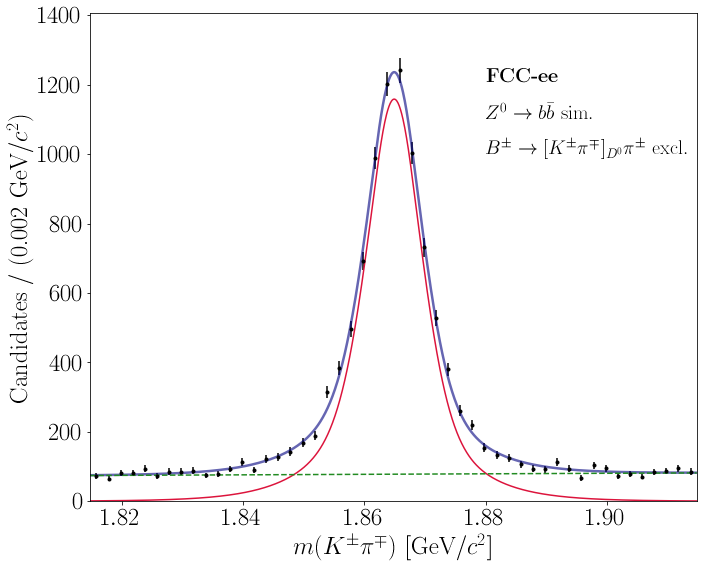

In [142]:
fig,ax = plt.subplots(figsize=(10,8))
lower, upper = obs_D.limits
low = lower[-1][0]
high = upper[0][0]
bin_width = 0.002
bins = int(float(high - low)/bin_width)
counts, bin_edges = np.histogram(D_data_np, bins, range=(low,high))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
err = np.sqrt(counts)
plt.errorbar(bin_centres, counts, yerr=err, fmt='o', markersize=3, color='black')
x_plot = np.linspace(low, high, num=1000)
y_plot_tot = zfit.run(pdf_D.pdf(x_plot, norm_range=obs_D))
plt.plot(x_plot, y_plot_tot*len(D_data_np)/bins*obs_D.area(), color='navy', linewidth=2.5, alpha=0.6)
y_plot_sig = zfit.run(pdf_sig_D.pdf(x_plot, norm_range=obs_D))
plt.plot(x_plot,y_plot_sig*params[n_sig_D]['value']/bins*obs_D.area(), color='crimson')
y_plot_bkg = zfit.run(pdf_bkg_D.pdf(x_plot, norm_range=obs_D))
plt.plot(x_plot,y_plot_bkg*params[n_bkg_D]['value']/bins*obs_D.area(), color='forestgreen', linestyle='dashed')
ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylabel("Candidates / (%.3f GeV/$c^2$)" % bin_width,fontsize=25)
plt.xlabel("$m(K^\pm \pi^\mp)$ [GeV/$c^2$]",fontsize=25)
plt.xlim(low,high)
ymin, ymax = plt.ylim()
plt.ylim(0,1.05*ymax)
plt.text(1.88,0.9*ymax,"\\textbf{FCC-ee}",fontsize=20)
plt.text(1.88,0.82*ymax,"$Z^0 \\to b\\bar{b}$ sim.",fontsize=20)
plt.text(1.88,0.74*ymax,"$B^\\pm \\to [K^\pm \pi^\mp]_{D^0} \\pi^\\pm$ excl.",fontsize=20)
plt.tight_layout()
fig.savefig(loc.PLOTS+f"/{file_type}_D0_M_fit.pdf")